<a href="https://colab.research.google.com/github/julie-dfx/causal-decision-analytics/blob/main/00_reboot_03_causal_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal identification: when effects are learnable

This notebook explores the distinction between estimation and identification. Through simulations, it demonstrates cases where causal effects can be recovered by adjustment and cases where they are fundamentally not identifiable from the data

*Topics: identification, selection bias, IV intuition*


### Results

 - this notebook shows that causal effects are identifiable only when the data and assumptions allow isolation of variation in the treatment independant of confounders.
 - Increasing sample size improves precision but does not resolve identification failure caused by unobserved confounding

 - Selection bias can arise from conditioning on post-treatment variables or restricting the samle based on outcomes that are influenced by the treatment
 Data filtering decisions can introduce bias even when regression models are otherwise correctly specified

 - Instrumental variables allow identification of causla effects in the presence of unobserved confounders by exploiting exogenous variation in the treatment

 - Difference-in-differences relies on the assumption that treated and control groups would have followed parallel trends if treatment were absent

 - Placebo difference-in-differences tests restricted to pre-treatment periods can help detect obvious violations of parallel trends, but cannot validate the identifying assumption.

 - Sensitivity Analysis can characterize how estimated efeeects change under assumptions about unobserved confounding, supporting decision-making when identification is imperfect

### Limitations

 - The examples assume simple data-genrating processes and focus on unobserved confounding as the primary source of non-identification. Other sources of non-identification, such as simultaneity or measurement error, are not yet explored

 - Selection mechanims are simulated explicitely; in real datasets, selection is often implicit and harder to diagnose

 - Instrument validity is assumed by construction. in real-world applications, the independance and exclusion assumptions are difficult to verify

 - parallel trends cannot be verified directly and may be violated by anticipation, composition changes or concurrent interventions

 - pre-trend diagnostics may lack power and cannot rule out gradual divergence or anticipation effects

 - sensitivity analyses rely on hypothetical assumptions about unobserved confounding and cannot replace identification through design

In [ ]:
import numpy as np
import statsmodels.api as sm

# Backdoor criterion


In [ ]:


#simulate a confounded world
np.random.seed(1)
n = 500

#Confounder:
Z = np.random.normal(0, 1, n) # --> affects both X and Y

#Treatment
X = 1.5 * Z + np.random.normal(0, 1, n)

#Outcome
Y = 2.0 * X + 3.0 * Z + np.random.normal(0, 1, n)

# The backdoor path is open X <-- Z --> Y
# True causal effect of X on Y = 2.0

In [ ]:
#Regression #1: no adjustment
X1 = sm.add_constant(X)
res1 = sm.OLS(Y, X1).fit()
res1.params

#result is far from 2.0

array([0.09138593, 3.40609307])

In [ ]:
#Regression #2: correct adjustment
X2 = sm.add_constant(np.column_stack([X, Z]))
res2 = sm.OLS(Y, X2).fit()
res2.params

#result: coefficient is close to 2; backdoor criterion in action

array([0.07616095, 2.0236437 , 2.98435111])

In [ ]:
#Regression 3: bad adjustment (collider)
C = X + Y + np.random.normal(0, 1, n)

X3 = sm.add_constant(np.column_stack([X, C]))
res3 = sm.OLS(Y, X3).fit()
res3.params

#result: X3 is wrong again (0.01); we introduced a bias by adjusting the wrong variable (collider)

array([0.04059645, 0.01346148, 0.76665627])

### Empirical demonstration of the backdoor criterion
 When the confounder Z is omitted, the regression coefficient on X is biased.
 Conditioning on Z blocks the backdoor path and recovers the true causal effect.
 Conditioning on a collider re-opens a non-causal path and introduces bias, even though model fit may improve



### Deep Dive

If we rerun for n in [100, 1000, 10000], we see that Bias persists and becomes more certain with more dta when identification is wrong

If we rerun fo increased noise vs signal Y = 2.0 * X + 3.0 * Z + np.random.normal(0, 5, n), we observe that variance increases, confidence intervals widen, but bias behaviour is unchanged. Variance is about uncertainty, bias is about structure

In [ ]:
# Create a richer graph in code
W = np.random.normal(0, 1, n)
Z2 = 0.5 * Z + np.random.normal(0, 1, n)

Y = 2.0 * X + 3.0 * Z + np.random.normal(0, 1, n)

In [ ]:
#Regression #1: control for X only
X1 = sm.add_constant(X)
res1 = sm.OLS(Y, X1).fit()
print(res1.summary())

#result is far from 2.0 (3.4)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     5351.
Date:                Mon, 19 Jan 2026   Prob (F-statistic):          1.48e-268
Time:                        10:13:50   Log-Likelihood:                -1025.3
No. Observations:                 500   AIC:                             2055.
Df Residuals:                     498   BIC:                             2063.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0460      0.084      0.545      0.5

In [ ]:
#Regression #2: control for X + W
X2 = sm.add_constant(np.column_stack([X, W]))
res2 = sm.OLS(Y, X2).fit()
print(res2.summary())

#result: controlling for sth that is not on the path (W) doesnt change the coeff on X, and is still wrong

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     2676.
Date:                Mon, 19 Jan 2026   Prob (F-statistic):          8.42e-267
Time:                        10:13:50   Log-Likelihood:                -1024.8
No. Observations:                 500   AIC:                             2056.
Df Residuals:                     497   BIC:                             2068.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0470      0.084      0.557      0.5

In [ ]:
#Regression #2: control for X + Z2 (Z2 is a descendant of Z, the confounder, but is not on the causal path to Y)
X2 = sm.add_constant(np.column_stack([X, Z2]))
res2 = sm.OLS(Y, X2).fit()
print(res2.summary())

#result: controlling for sth that is not on the path (Z2), even if a descendant of the confounder doesnt change the coeff on X, and is still wrong

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     2953.
Date:                Mon, 19 Jan 2026   Prob (F-statistic):          1.49e-276
Time:                        10:13:50   Log-Likelihood:                -1002.2
No. Observations:                 500   AIC:                             2010.
Df Residuals:                     497   BIC:                             2023.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0614      0.081      0.761      0.4

In [ ]:
#Regression #2: control for X + Z + W (controlling both for the confounder and for sth that is not on the causal path)
X2 = sm.add_constant(np.column_stack([X, Z, W]))
res2 = sm.OLS(Y, X2).fit()
print(res2.summary())

#result: controlling for the confounder + for sth random gives correct results. It's just useless to control for W

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     6450.
Date:                Mon, 19 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:13:50   Log-Likelihood:                -718.87
No. Observations:                 500   AIC:                             1446.
Df Residuals:                     496   BIC:                             1463.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0314      0.046      0.684      0.4

### REAL EXAMPLE

- X = compensation issued
- Y = 28-day retention
- Z = order issue severity
- C = basket value



1.   severity --> compensation --> retention
2.   severity --> retention
3.   compensation --> basket value <-- retention


The backdoor path is open: severity is the confounder
Basket Value is influenced by both X and Y, it's the collider and should not be controlled for




# Identification vs Estimation

Can this causal effect be learned from the data at all, even with infinite data?


In [ ]:
## We simulate 2 worlds, one where regression is biased but fixable by adjustment, one where it's not

## World A
np.random.seed(1)
n = 1000

Z = np.random.normal(0, 1, n)
X = Z + np.random.normal(0, 1, n)
Y = 2 * X + 3 *  Z + np.random.normal(0, 1, n)

In [ ]:
#run 2 regressions

#unadjusted
res_unadj = sm.OLS(Y, sm.add_constant(X)).fit()

#adjusted
res_adj = sm.OLS(Y, sm.add_constant(np.column_stack([X, Z]))).fit()

print(res_unadj.summary())
print(res_adj.summary())

# results: adjusted ~2, unadj <>2 ; the effect is identifiable because a valid adjustment set exists

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     4453.
Date:                Mon, 19 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:13:50   Log-Likelihood:                -2255.0
No. Observations:                1000   AIC:                             4514.
Df Residuals:                     998   BIC:                             4524.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.073      0.032      0.9

In [ ]:
# World B - not identifiable

np.random.seed(1)
# n = 10000
U = np.random.normal(0, 1, n) # unobserved confounder

X = U + np.random.normal(0, 1, n)
Y = 2 * X + U + np.random.normal(0, 1, n)

In [ ]:
res = sm.OLS(Y, sm.add_constant(X)).fit()
print(res.summary())

#result: 2, 4, false. not identifiable. When increasing n, the results converge but not to 2 ==> not a variance problem, but an identification failure


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     8665.
Date:                Mon, 19 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:13:50   Log-Likelihood:                -1592.3
No. Observations:                1000   AIC:                             3189.
Df Residuals:                     998   BIC:                             3198.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0123      0.038     -0.326      0.7

## Identification vs Estimation

In world A, the causal effect of X on Y is identifiable because a valid adjustment set exists. Conditioning on Z blocks all backdoor paths

In world B, the causal effect is not identifiable from the observed data because the confounder is unobserved. Increasing sample size improves precision but does not remove bias

# Selection bias and post-treatment variables
Why "cleaning data" often breaks causality.

This section simulates a situation where : the casual effect is identifiable in principle, but the selection decision destroys identifiability (eg: "let's look only at delivered orders"

In [ ]:
np.random.seed(1)
n = 2000

#Unobserved customerquality
U = np.random.normal(0, 1, n)

#treatment (compensation)
X = U + np.random.normal(0, 1, n)

#outcome (retention)
Y = 2 * X + U + np.random.normal(0, 1, n)

## U affects both treatment and outcome
## in the full population, this is confounded but conceptually identifiable iif U were observed (it is not)

In [ ]:
# Introduce bias:

#selection variable (delivered / observed)
S = (X + Y + np.random.normal(0, 1, n)) > 0

## S is affected by both X and Y, it's a Collider
## Conditioning on S is selection bias

In [ ]:
# Regression on the full population

res_full = sm.OLS(Y, sm.add_constant(X)).fit()
print(res_full.summary())

# this is biased because of the confounder, but that's not the topic for now

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                 1.642e+04
Date:                Mon, 19 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:13:50   Log-Likelihood:                -3242.1
No. Observations:                2000   AIC:                             6488.
Df Residuals:                    1998   BIC:                             6499.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0330      0.027      1.203      0.2

In [ ]:
# regression on the selected sample:

X_sel = X[S]
Y_sel = Y[S]

res_sel = sm.OLS(Y_sel, sm.add_constant(X_sel)).fit()
print(res_sel.summary())

# the coefficient changes --> this is selection bias

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     3157.
Date:                Mon, 19 Jan 2026   Prob (F-statistic):          2.17e-313
Time:                        10:13:50   Log-Likelihood:                -1598.7
No. Observations:                1014   AIC:                             3201.
Df Residuals:                    1012   BIC:                             3211.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5503      0.056      9.783      0.0

### Selection bias vs post-treatment variables:
Restricting the analysis to selected observations is conditioning on a variable that is influenced by both the treatment and the outcome. This introduces bias by opening a non-causal path between X and Y, even if the full population effect were otherwise identifiable

#Instrumental Variables (IV)

IV is used when the causal effect of X on Y is not identifiable by aadjustement, becasue a confounder is unobserved; but we do have a variable that creates exogenous variation in X --> we use external variation in X that is unrelated to the confounder

In [ ]:
# simulate a world with unobserved confounding

import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS

np.random.seed(1)
n = 3000

# unobserved confounder
U = np.random.normal(0, 1, n)

# Instrument
Z = np.random.normal(0, 1, n)

#treatment (endogenous)
X = 2 * Z + U + np.random.normal(0, 1, n)

# Outcome
Y = 3 * X + U + np.random.normal(0, 1, n)


# U affects both X and Y, it's the confounder
# Z affects X but not Y directly
# Z is independant of U --> Ideal IV world

In [ ]:
# regression (naive)
res_ols = sm.OLS(Y, sm.add_constant(X)).fit()
print(res_ols.summary())

# results: coeff > 3 ; bias persists whatever n

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 9.790e+04
Date:                Mon, 19 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:20:32   Log-Likelihood:                -5169.0
No. Observations:                3000   AIC:                         1.034e+04
Df Residuals:                    2998   BIC:                         1.035e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0324      0.025      1.310      0.1

In [ ]:
# endogenous regressor
X_endog = X

#exogenous regressor
X_exog = np.ones((n, 1))

# instruments = exogenous regressors + instrument Z
Z_instr = np.column_stack([np.ones(n), Z])

iv_res = IV2SLS(Y, X_exog, X_endog, Z_instr).fit()
print(iv_res.summary())

TypeError: IV2SLS.__init__() takes from 3 to 4 positional arguments but 5 were given

In [ ]:
# IV2SLS code doesnt work so let's do the 2 steps manually:

first_stage = sm.OLS(X, sm.add_constant(Z)).fit()
print(first_stage.summary())

# coeff on Z is large and significant, which confirms relevance

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     6113.
Date:                Mon, 19 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:46:48   Log-Likelihood:                -5268.1
No. Observations:                3000   AIC:                         1.054e+04
Df Residuals:                    2998   BIC:                         1.055e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0150      0.026      0.585      0.5

In [ ]:
#generate predicted treatment

X_hat = first_stage.predict(sm.add_constant(Z))

# X_hat contains only the variation in X that is due to Z

In [ ]:
#second stage

second_stage = sm.OLS(Y, sm.add_constant(X_hat)).fit()
print(second_stage.summary())


#results: coeff on X_hat is very close to 3 --> this is the IV estimate

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     4256.
Date:                Mon, 19 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:49:18   Log-Likelihood:                -9117.8
No. Observations:                3000   AIC:                         1.824e+04
Df Residuals:                    2998   BIC:                         1.825e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0377      0.092      0.409      0.6

### Interpretation

- first stage removed the confounded part of X
- second stage used only the exogenous variation
- as a result, bias is gone



### Instrumental variables via two-stage least squares

Ordinary Least Squares (OLS) fails to recover the causal effect of X on Y due to unobserved confounding.

Two-stage least squares was implemented manually by first regressing the treatment X on the instrument Z to extract exogenous variation, and then regressing the outcome Y on the predicted treatment.

Under the relevance, independance and exclusion IV assumptions, this procedure recovers the true causal effect using variation in X that is unrelated to the unobserved confounder




### Conclusion:
Instrumental variables are used full when confounding cannot be addressed by adjustment. An instrument provides exogenous variation in the treatment that is independant of confounders and affects the outcome only through the treatment (strongly and significantly). IV identifies a causal effect under strong assumptions that must be justified using domain knowledge rather than statistical tests

# Difference-in-Differences (DiD)

"How did Y change for treated units relative to how it would have changed without treatment?"

Compares changes over time, substracting away common trends

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

np.random.seed(1)
n = 1000

#groups
group = np.random.binomial(1,0.5, n) # 1 = treated group

#time
time = np.random.binomial(1, 0.5, n) # 1 = post-treatment

#baseline outcome
Y = 5.0 + 2 * group + 3 * time # Initialize Y as float to prevent type error

# treatment efect (only for treated group in post-period)
treatment_effect = 4
Y += treatment_effect * group * time

# noise
Y += np.random.normal(0, 1, n)

df = pd.DataFrame({
    "Y": Y,
    "group": group,
    "time": time
})

# interpretation: groups differ at baseline; outcome evolves over time; treatment only affects treated group after intervention, true DiD = 4

In [3]:
# naive comparison: compare means manually
df.groupby(["group", "time"])["Y"].mean()

# raw differences are not what we want to read (4)


group  time
0      0        4.932938
       1        7.974456
1      0        7.056576
       1       13.953337
Name: Y, dtype: float64

In [5]:
# correct thinking: DiD regression (canonical)

#create the interaction term, it's 1 only for post-treatment, 0 otherwise
#this is the DiD estimator
df["interaction"] = df["group"] * df["time"]

did_res = sm.OLS(
    df["Y"], # this is the outcome, eg retention
    sm.add_constant(df[["group", "time", "interaction"]])
    # the constant represents the baseline outcome level for the control pre -> it is the anchor of the model
    # the regressors grpup, time and interaction: each term plays a specific causal role:
    ## group captures time-invariant differences between groups
    ## time absordbs seasonailty, macro trends...
    ## interaction --> this is the DiD coefficient; this is the causal effect under parallel trends
).fit() # statsmodel solves Y = B0 + B1xgroup +B2xtime + B3x(groupxtime) + E; B3 is the DiD estimate

print(did_res.summary())

#coeff on interaction is ~4 --> 3.8 is the DiD estimate

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     3763.
Date:                Tue, 20 Jan 2026   Prob (F-statistic):               0.00
Time:                        09:51:44   Log-Likelihood:                -1432.1
No. Observations:                1000   AIC:                             2872.
Df Residuals:                     996   BIC:                             2892.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.9329      0.066     74.798      

### Difference-in-Differences estimation
DiD estimates the causal effect of a treatment by comparing changes in outcomes over time between treated and control groups. Under the parallel trends assumption, the interaction between treatment group and post period identifies the causal effect.

# Diagnosing DiD Assumptions
How do I assess if the parallel trends asusmptions is plausible, without over-claiming certainty

In [8]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

np.random.seed(1)
n_units = 200
n_periods = 5 # 3 pre, 1 treatment, 1 post

#group assignment
treated = np.random.binomial(1, 0.5, n_units) # 1 = treated group

rows = []
for i in range(n_units):
  base = np.random.normal(10, 1)
  trend = np.random.normal(1.0, 0.2) # common trend

  for t in range(n_periods):
    time = t
    post = int(t>=3)

    #treatment only if in post
    effect = 4 * treated[i] * post
    y = base + trend * time + effect + np.random.normal(0, 0.5)
    rows.append([i, treated[i], time, post, y])

df = pd.DataFrame(
    rows,
    columns=["unit", "treated", "time", "post", "Y"]
)

In [9]:
df.head()
#this created multiple pre-periods, one post-treatment period, clean parallel trends by construction

,unit,treated,time,post,Y
0,0,0,0,0,10.194068
1,0,0,1,0,11.542773
2,0,0,2,0,12.170115
3,0,0,3,1,12.231430
4,0,0,4,1,15.091938


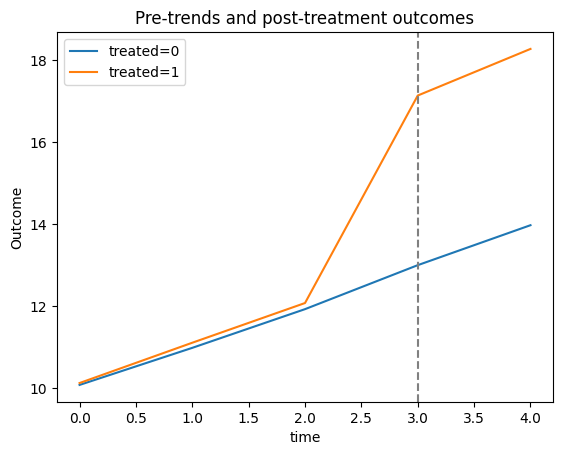

In [14]:
#visual pre-trend check

import matplotlib.pyplot as plt

mean_df = df.groupby(["treated", "time"])["Y"].mean().reset_index()

for g in [0, 1]:
  subset = mean_df[mean_df["treated"] == g]
  plt.plot(subset["time"], subset["Y"], label=f"treated={g}")

plt.axvline(3, linestyle="--", color="gray")
plt.legend()
plt.xlabel("time")
plt.ylabel("Outcome")
plt.title("Pre-trends and post-treatment outcomes")
plt.show()

#treated and control have parallel pre-trend

In [22]:
#placebo DiD (pretend treatment happened earlier)

#create a pre-treatment only dataset
df_pre = df[df["time"] < 3].copy() # if we include post-treatment data here, then the real effect contaminates the pacebo and the test is invalid

df_pre["placebo_post"] = (df_pre["time"] >= 2).astype(int)
df_pre["placebo_interaction"] = df_pre["treated"] * df_pre["placebo_post"]

#treated = group that WILL be treated ater
#placebo_post - fake "after" period
#placebo_interaction = fake exposure
#this mirrors the real DiD structure

In [23]:
#placebo regression

placebo_res = sm.OLS(
    df_pre["Y"],
    sm.add_constant(df_pre[["treated", "placebo_post", "placebo_interaction"]])
).fit()

print(placebo_res.summary())

#placebo_interaction is close to zero : there is no systematic difference in trends before treatment

#what this can tell us is that there us no obvious pretrend divergence; the DiD design is not blatnantly broken

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     69.45
Date:                Fri, 23 Jan 2026   Prob (F-statistic):           1.59e-38
Time:                        09:56:34   Log-Likelihood:                -932.30
No. Observations:                 600   AIC:                             1873.
Df Residuals:                     596   BIC:                             1890.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.5302    

### Pre-trends and Placebo Difference-in-differences

Post-treatment trends were examind visually.
A placebo DiD was conducted by restricting the data to pre-treatment periods and assigning a fake treatment tim. The absence of a significant placebo interaction suggests no differential pre-trends between treated and contro groups, which is consistent with the parallel trends assumption but does not prove t.
A placebo DiD can falsify a design but cannot validate it (the counterfactual post-treatment trajectory is unobserved)

# Robustness and Sensitivity
What do I do when I cannot fully identify a causal effect, but leadership still needs to decide?

In [2]:
import numpy as np
import statsmodels.api as sm

np.random.seed(6)
n = 2000

# observed confounder
Z = np.random.normal(0, 1, n)

# Unobserved confounder
U = np.random.normal(0, 1, n)

# Treatment
X = 1.5 * Z + 1.0 * U + np.random.normal(0, 1, n)

# Outcome
Y = 2.0 * X + 2.0 * Z + 2.0 * U + np.random.normal(0, 1, n) # true causal effect of X on Y is 2, but you cannot observe U

In [4]:
#naive regression
res_naive = sm.OLS(Y, sm.add_constant(X)).fit()
print(res_naive.summary())

#results are biased (coeff on X ~ 3.1)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 2.704e+04
Date:                Sun, 25 Jan 2026   Prob (F-statistic):               0.00
Time:                        08:14:42   Log-Likelihood:                -3944.1
No. Observations:                2000   AIC:                             7892.
Df Residuals:                    1998   BIC:                             7903.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0478      0.039      1.227      0.2

In [5]:
#adjusted regression (still biased)
res_adj = sm.OLS(Y, sm.add_constant(np.column_stack([X, Z]))).fit()
print(res_adj.summary())

#results are still biased (coeff on X ~ 2.9)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                 1.424e+04
Date:                Sun, 25 Jan 2026   Prob (F-statistic):               0.00
Time:                        08:15:08   Log-Likelihood:                -3895.1
No. Observations:                2000   AIC:                             7796.
Df Residuals:                    1997   BIC:                             7813.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0518      0.038      1.363      0.1

### sensitivity via hypothetical confounding
we stress-test the estimate by simulating how strong U would have to be to flip conclusions


In [13]:
#create a loop
effects = []
strengths = np.linspace(0, 3, 20)
for strength in strengths:
  Y_alt = 2.0 * X + 2.0 * Z + strength * U + np.random.normal(0, 1, n)
  res_alt = sm.OLS(Y_alt, sm.add_constant(np.column_stack([X, Z]))).fit()
  effects.append(res_alt.params[1])

effects

[np.float64(2.0137874958700777),
 np.float64(2.090375749679929),
 np.float64(2.136799127401817),
 np.float64(2.2287161004302827),
 np.float64(2.3024649109113042),
 np.float64(2.3618027482477775),
 np.float64(2.4241644279880923),
 np.float64(2.5269609032754086),
 np.float64(2.617678891554908),
 np.float64(2.659184995111462),
 np.float64(2.7393640021359564),
 np.float64(2.8167244503179463),
 np.float64(2.8840050672480815),
 np.float64(2.959308343450572),
 np.float64(3.0561141134854783),
 np.float64(3.1432607086470097),
 np.float64(3.182676684567496),
 np.float64(3.2782140301852185),
 np.float64(3.3597395918381765),
 np.float64(3.4083790523681747)]

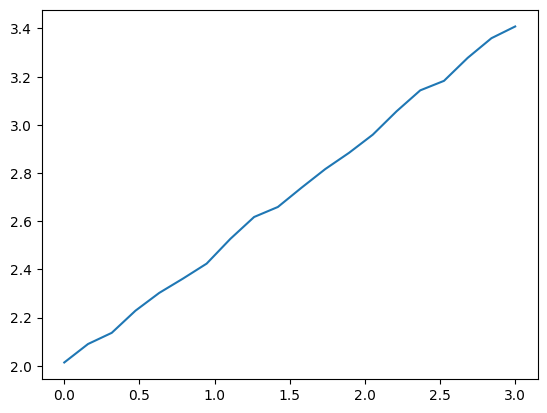

In [14]:
import matplotlib.pyplot as plt

plt.plot(strengths, effects)
plt.show()

#here the bias is positive, U makes both X and Y larger --> coherent but not good for demo here

In [17]:
#create a loop
effects = []
strengths = np.linspace(0, 4, 20)
for strength in strengths:
  Y_alt = 2.0 * X + 2.0 * Z - strength * U + np.random.normal(0, 1, n) #negative confounding
  res_alt = sm.OLS(Y_alt, sm.add_constant(np.column_stack([X, Z]))).fit()
  effects.append(res_alt.params[1])

effects

[np.float64(2.001171422425937),
 np.float64(1.8899323516616944),
 np.float64(1.8186047159108978),
 np.float64(1.6857258857554365),
 np.float64(1.647520644213909),
 np.float64(1.4969401965195859),
 np.float64(1.370237505865226),
 np.float64(1.2840730884182405),
 np.float64(1.192667673161926),
 np.float64(1.1064929734977587),
 np.float64(1.0102937066242093),
 np.float64(0.9234540991094646),
 np.float64(0.8006429842687914),
 np.float64(0.6974442819356248),
 np.float64(0.590051873397933),
 np.float64(0.5120416799809083),
 np.float64(0.40034740780022793),
 np.float64(0.27247357826505975),
 np.float64(0.1822791442064989),
 np.float64(0.09090232874230272)]

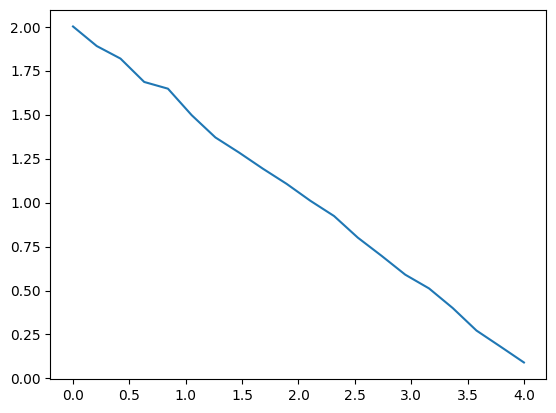

In [18]:
import matplotlib.pyplot as plt

plt.plot(strengths, effects)
plt.show()

#at strength = 0, estimate ~2 ; then causal effect decreases while strength increases, may cross zero at some point
#this answers "how strong would the unobserved confounding need to be to overturn the conclusions?"

Sensitivty analysis was conducted under alertanive assumptions about the direction and magnitude of unobserved confounding. Depending on wether the confounder reinforces or counteracts the treatment effect, the estimated coefficient may increase or decrease, highlighting the importance of directional assumptions in robustness analysis